## Import libraries


In [613]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Load and preprocess data


In [614]:
# Load data
btc_data = pd.read_parquet("../datasets/BTCUSDT/")
btc_data.index = pd.to_datetime(btc_data.index, unit="ms")
btc_data.drop(
    columns=[
        "TAKER_BUY_BASE_ASSET_VOLUME",
        "TAKER_BUY_QUOTE_ASSET_VOLUME",
        "YEAR_AND_MONTH",
    ],
    inplace=True,
)

In [615]:
# Load labels
labels = pd.read_parquet("../datasets/LABEL_BTCUSDT/")
labels.index = pd.to_datetime(labels.index, unit="ms")
labels.drop(columns="SYMBOL", inplace=True)

In [616]:
print(labels.head())
btc_data.head()

                        LABEL
OPEN_TIME                    
2017-09-16 10:00:00  0.393885
2017-09-16 11:00:00  0.390215
2017-09-16 12:00:00  0.360434
2017-09-16 13:00:00  0.398650
2017-09-16 14:00:00  0.451718


,OPEN,HIGH,LOW,CLOSE,VOLUME,QUOTE_ASSET_VOLUME,NUMBER_OF_TRADES
OPEN_TIME,,,,,,,
2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.189061,9333.620962,9
2017-08-17 04:05:00,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000,0
2017-08-17 04:10:00,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000,0
2017-08-17 04:15:00,4261.48,4264.88,4261.48,4261.48,0.484666,2065.447829,9
2017-08-17 04:20:00,4264.88,4266.29,4264.88,4266.29,2.328570,9931.161124,11


In [617]:
btc_data.loc[pd.Timestamp("2017-12-18 12:00:00") :].head()

,OPEN,HIGH,LOW,CLOSE,VOLUME,QUOTE_ASSET_VOLUME,NUMBER_OF_TRADES
OPEN_TIME,,,,,,,
2017-12-18 12:00:00,19116.11,19199.00,19114.97,19152.00,64.422665,1.233095e+06,343
2017-12-18 12:05:00,19175.00,19198.97,19116.98,19180.00,19.845825,3.802186e+05,284
2017-12-18 12:10:00,19180.00,19300.00,19116.13,19212.23,44.649825,8.568738e+05,410
2017-12-18 12:15:00,19212.23,19212.26,19143.50,19179.99,42.377449,8.128457e+05,288
2017-12-18 12:20:00,19179.99,19197.88,19114.97,19114.97,33.430487,6.407821e+05,338


## Calculate typical price and handle missing timestamps


In [618]:
btc_price = pd.DataFrame(
    index=pd.date_range(start=btc_data.index[0], end=btc_data.index[-1], freq="5min")
)
btc_price["PRICE"] = (btc_data["HIGH"] + btc_data["LOW"] + btc_data["CLOSE"]) / 3
btc_price.interpolate(method="time", inplace=True)

## Calculate Bollinger Bands


In [619]:
def bollinger_bands(data: pd.DataFrame, window_size=20, num_of_std=2):
    rolling_mean = data.rolling(window=window_size).mean()
    rolling_std = data.rolling(window=window_size).std()
    upper_band = rolling_mean + (rolling_std * num_of_std)
    lower_band = rolling_mean - (rolling_std * num_of_std)
    return rolling_mean, upper_band, lower_band

## Probability of the price using Geometric Brownian Motion


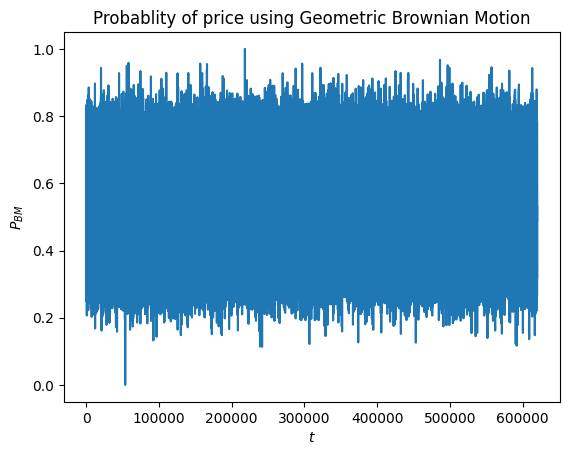

In [620]:
mu = 0.1
n = btc_price.shape[0]
dt = 1e-5
x0 = 1
sigma = 0.3
np.random.seed(1012)
p_bm = np.exp((mu - sigma**2 / 2) * dt + sigma * np.random.normal(0, dt, n))
p_bm = MinMaxScaler().fit_transform(p_bm.reshape(-1, 1)).flatten()
btc_price["P_BM"] = p_bm
plt.plot(p_bm)
plt.xlabel("$t$")
plt.ylabel("$P_{BM}$")
plt.title("Probablity of price using Geometric Brownian Motion")
plt.show()

## Pipeline for scaling labels

In [621]:
price_pipline = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", MinMaxScaler())]
)

## Calculate return rate (R) and price volatility change (V)


In [622]:
for i in range(101, 102):
    # R
    btc_price["R"] = 100 * (btc_price["PRICE"].shift(-i) / btc_price["PRICE"] - 1)
    btc_price["R"].fillna(method="ffill", inplace=True)

    # V
    std_backward = SimpleImputer(strategy="mean").fit_transform(
        btc_price["PRICE"].rolling(round(2 * i)).std().values.reshape(-1, 1)
    )
    std_forward = SimpleImputer(strategy="mean").fit_transform(
        btc_price["PRICE"].rolling(i).std().shift(-i).values.reshape(-1, 1)
    )
    btc_price["V"] = std_forward / std_backward

    # Predict labels
    cal_labels = btc_price["R"] / (2 * np.sqrt(btc_price["V"] * btc_price["P_BM"]))
    cal_labels.replace([np.inf, -np.inf], np.nan, inplace=True)
    imputer = price_pipline.fit_transform(cal_labels.values.reshape(-1, 1)).flatten()
    cal_labels = pd.Series(imputer, index=cal_labels.index)
    pred_labels = cal_labels.loc[labels.index]

    # Correlation
    print(i, np.corrcoef(pred_labels, labels["LABEL"]))
    print(
        i,
        mean_absolute_error(pred_labels, labels["LABEL"]),
        mean_squared_error(pred_labels, labels["LABEL"]),
    )
    # sns.kdeplot(data=pred_labels)
    # plt.title(i)
    # sns.kdeplot(data=labels, fill=True)
    # plt.show()

101 [[1.       0.544675]
 [0.544675 1.      ]]
101 0.04454860756663768 0.004274832333591983


In [623]:
btc_price.head()

,PRICE,P_BM,R,V
2017-08-17 04:00:00,4267.840000,0.610030,3.576907,0.310702
2017-08-17 04:05:00,4261.480000,0.474386,3.649436,0.307459
2017-08-17 04:10:00,4261.480000,0.591640,3.810570,0.304268
2017-08-17 04:15:00,4262.613333,0.364038,3.796028,0.300959
2017-08-17 04:20:00,4265.820000,0.547705,3.551799,0.297412


## Define function for predicting labels

In [624]:
def predict(data: pd.Series, time: pd.DatetimeIndex, file_name: str):
    agg_data = data.resample("H").mean().shift(1).loc[time]
    predict_labels = agg_data["R"] / (2 * np.sqrt(agg_data["V"] * agg_data["P_BM"]))
    labels = price_pipline.fit_transform(predict_labels.values.reshape(-1, 1)).flatten()
    submission = pd.DataFrame(
        {"OPEN_TIME": time.astype(np.int64) // 10**6, "PREDICTION": labels}
    )
    submission.to_csv("C:/Users/nguye/Downloads/" + file_name, index=False)
    sns.kdeplot(labels, fill=True)
    return labels

## Prediction for public test round


array([0.32598842, 0.26835637, 0.34535599, ..., 0.47561184, 0.45878067,
       0.43802585])

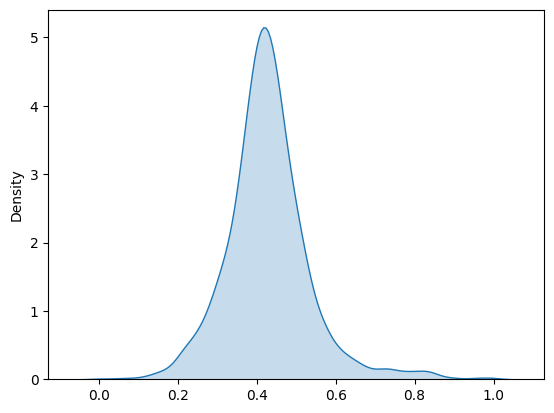

In [625]:
predict(
    btc_price,
    pd.date_range(start="2022-12-15", end="2023-03-05", freq="H"),
    "public_test_v5.csv",
)

## Prediction for private test round

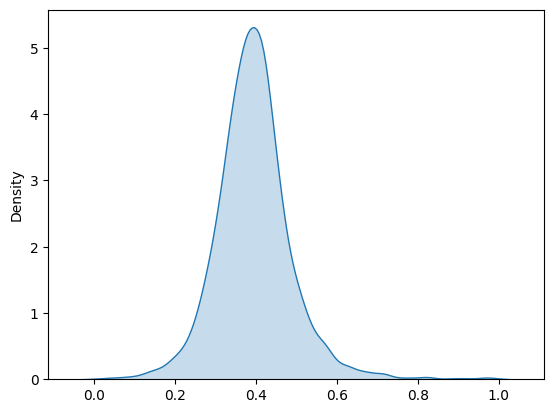

In [630]:
lb = predict(
    btc_price,
    pd.date_range(start="2023-02-01", end="2023-06-15", freq="H"),
    "private_test_22_7.csv",
)

## Predict by using calculated labels

In [627]:
def pred_v2(time,file_name):
    resample_data = cal_labels.resample("H").median().shift(1)
    lb = price_pipline.fit_transform(resample_data.loc[time].values.reshape(-1, 1)).flatten()
    x = pd.DataFrame(
        {"OPEN_TIME": time.astype(np.int64) // 10**6, "PREDICTION": lb}
    )
    x.to_csv("C:/Users/nguye/Downloads/" + file_name, index=False)
    sns.kdeplot(lb, fill=True)
    plt.show()


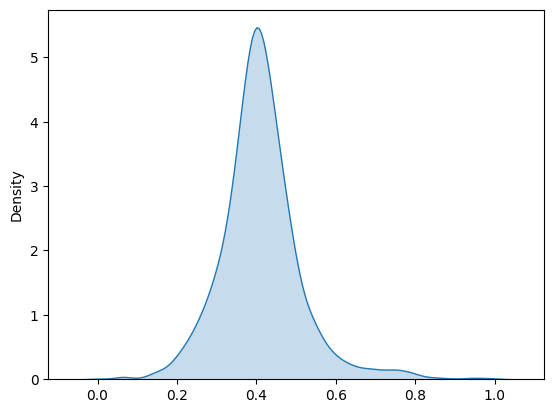

In [628]:
pred_v2(
    pd.date_range(start="2022-12-15", end="2023-03-05", freq="H"),
    "public_test_v6.csv",
)

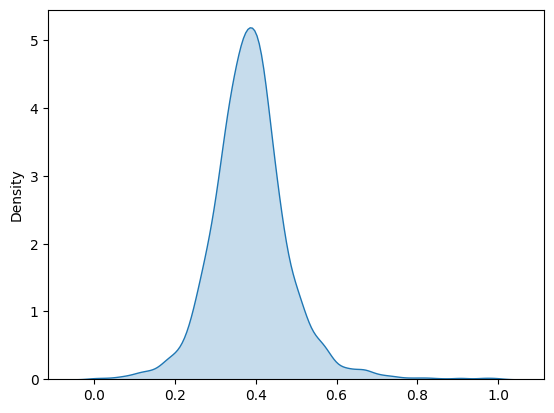

In [629]:
pred_v2(
    pd.date_range(start="2023-02-01", end="2023-06-15", freq="H"),
    "private_test_22_7_v2.csv",
)